### Unsupervised Analysis of Congressional Laws

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

__Import data__

In [2]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)

In [3]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [4]:
laws_summarys = pd.read_csv('laws_summary.csv')

__Count Vectorizer__

In [235]:
count_vectorizer = CountVectorizer(ngram_range=(0, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]{3,100}\\b",
                                   max_df=0.8,
                                   min_df = 50)
count_vectorizer.fit(laws_list)



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=50,
        ngram_range=(0, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]{3,100}\\b',
        tokenizer=None, vocabulary=None)

In [236]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(laws_list).transpose()

In [237]:
np.shape(counts)

(17274, 3896)

__Convert to gensim__

We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [238]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

__Map matrix rows to words (tokens)__

We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [239]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [240]:
len(id2word)

17274

## LDA
At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics (3).

In [241]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=3)

In [242]:
lda.print_topics(num_words=50)

[(0,
  '0.009*"state" + 0.008*"secretary" + 0.007*"subsection" + 0.006*"federal" + 0.006*"paragraph" + 0.005*"agency" + 0.005*"title" + 0.005*"general" + 0.004*"inserting" + 0.004*"information" + 0.004*"including" + 0.004*"program" + 0.004*"education" + 0.004*"striking" + 0.004*"services" + 0.004*"local" + 0.004*"described" + 0.003*"term" + 0.003*"year" + 0.003*"programs" + 0.003*"national" + 0.003*"activities" + 0.003*"commission" + 0.003*"subparagraph" + 0.003*"following" + 0.003*"date" + 0.003*"provide" + 0.003*"amended" + 0.003*"educational" + 0.003*"funds" + 0.003*"appropriate" + 0.003*"fiscal" + 0.003*"assistance" + 0.003*"grant" + 0.002*"eligible" + 0.002*"means" + 0.002*"service" + 0.002*"report" + 0.002*"financial" + 0.002*"provided" + 0.002*"plan" + 0.002*"requirements" + 0.002*"board" + 0.002*"school" + 0.002*"agencies" + 0.002*"secretary shall" + 0.002*"entity" + 0.002*"children" + 0.002*"fiscal year" + 0.002*"based"'),
 (1,
  '0.013*"defense" + 0.010*"secretary" + 0.009*"s

In [243]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [244]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [245]:
len(lda_docs)

3896

In [246]:
lda_docs[900]

[(2, 0.99110745781226373)]

## NMF

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]{3,100}\\b",
                                   max_df = 0.80,
                                   min_df = 50)

In [6]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [7]:
dtm

<3896x17274 sparse matrix of type '<class 'numpy.float64'>'
	with 2505068 stored elements in Compressed Sparse Row format>

In [8]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
# dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [9]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: office building post office building post facility service located facility united states postal postal service postal reference located building references building approved building note service designation facility designate facility states facility facility referred

Topic: 1
Keywords: health secretary state program year fiscal paragraph services education fiscal year care subsection research grant programs secretary shall subparagraph assistance plan eligible

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united states united infrastructure congressional section designation comm transportation located congress designate reference regulation paper record document paper

Topic: 3
Keywords: inserting striking amended amended striking title paragr

In [10]:
np.shape(dtm_nmf)

(3896, 20)

__Investigate whether Topics identified match title__

In [11]:
def rank_df(df,rank):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [12]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

In [13]:
rank_df(nmf_df,1)
rank_df(nmf_df,2)
rank_df(nmf_df,3)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

In [14]:
nmf_df = nmf_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [15]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),size = 20,replace = False)]

,id,title,MAX1,MAX2,MAX3
2387,c110publ344,H.R.923 - Emmett Till Unsolved Civil Rights Crime Act of 2007 110th Congress (20...,7,16,17
2109,c109publ94,S.156 - Ojito Wilderness Act 109th Congress (2005-2006),4,18,13
2365,c110publ324,S.2617 - Veterans' Compensation Cost-of-Living Adjustment Act of 2008 110th Cong...,3,8,4
2051,c109publ476,H.R.4709 - Telephone Records and Privacy Protection Act of 2006 109th Congress (...,7,3,16
2896,c111publ43,S.1513 - A bill to provide for an additional temporary extension of programs under the Small Bus...,15,3,6
2738,c111publ246,H.R.4505 - To enable State homes to furnish nursing home care to parents any of whose children d...,8,17,17
1493,c108publ421,H.R.1964 - Highlands Conservation Act 108th Congress (2003-2004),4,19,10
2815,c111publ315,H.R.6184 - To amend the Water Resources Development Act of 2000 to extend and modify the program...,18,3,9
3408,c113publ25,"H.R.1092 - To designate the air route traffic control center located in Nashua, New Hampshire, a...",6,14,8
2653,c111publ17,S.J.Res.8 - A joint resolution providing for the appointment of David M. Rubenstein as a citizen...,12,10,14


__TSNE Visualization__

In [58]:
tsne_model = TSNE(learning_rate=200,perplexity=50, n_iter=5000,verbose=2)

In [59]:
tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.017157
[t-SNE] Iteration 25: error = 1.7420659, gradient norm = 0.0000854
[t-SNE] Iteration 25: gradient norm 0.000085. Finished.
[t-SNE] Iteration 50: error = 1.7196347, gradient norm = 0.0136240
[t-SNE] Iteration 75: error = 1.6306713, gradient norm = 0.0092098
[t-SNE] Iteration 100: error = 1.6076962, gradient norm = 0.0083330
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.607696
[t-SNE] Iteration 125: error = 1.4601042, gradient norm = 0.0048424
[t-SNE] Iteration 150: error = 1.4166509, gradient norm = 0.0042653
[t-SNE] Iteration 175: error = 1.4059184, gradient norm = 0.0041417
[t-SNE] Iteration 

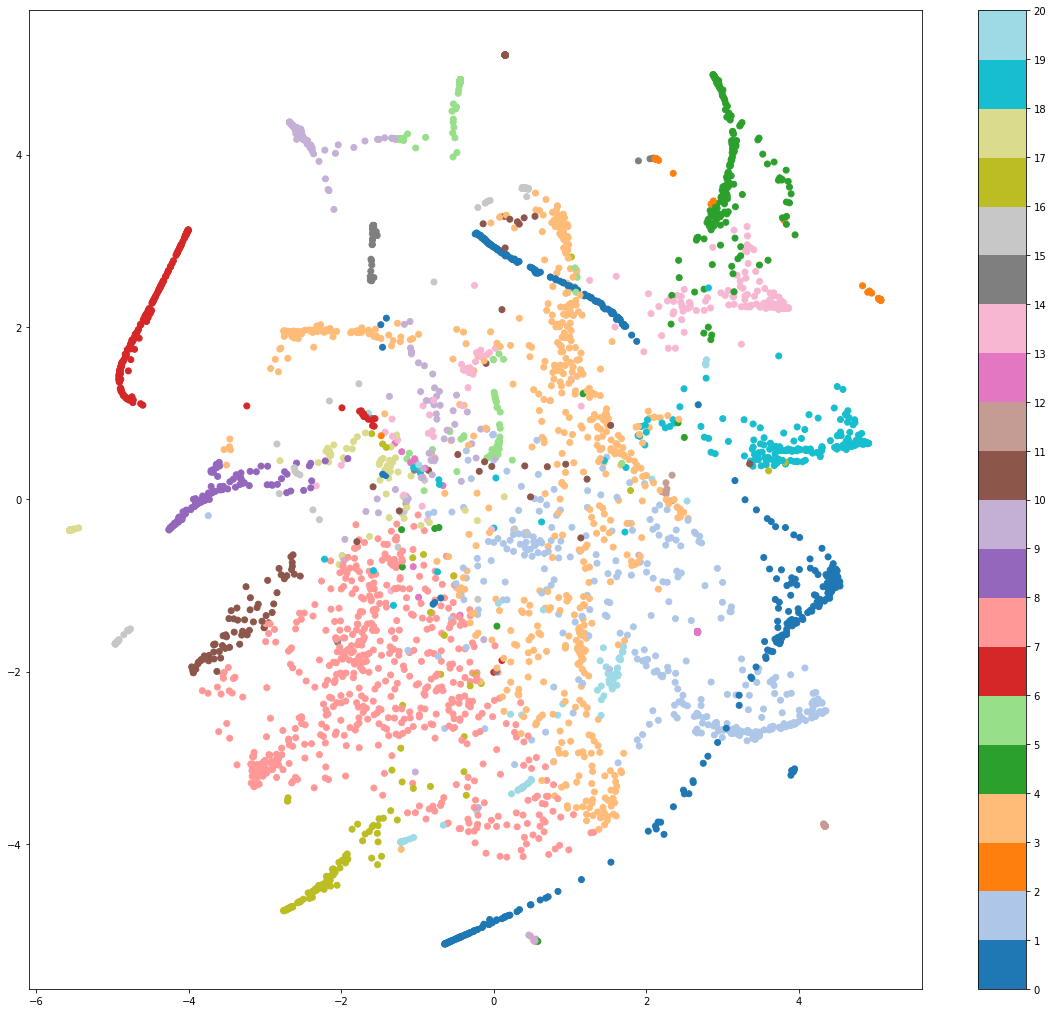

In [60]:
plt.figure(figsize=(20,18))
plt.scatter(tsne_nmf[:,0], tsne_nmf[:,1], c=nmf_df.MAX1, cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num)
plt.show()

## Try LSA too! ... but for now, try clustering on what I have